# LAB #2
The purpose of this laboratory is to make you practice with the data preparation process. More specifically,you will tackle the task with tabular and textual input data, learning how to handle anomalies in the data,missing values and more.

**Matplotlib availability**

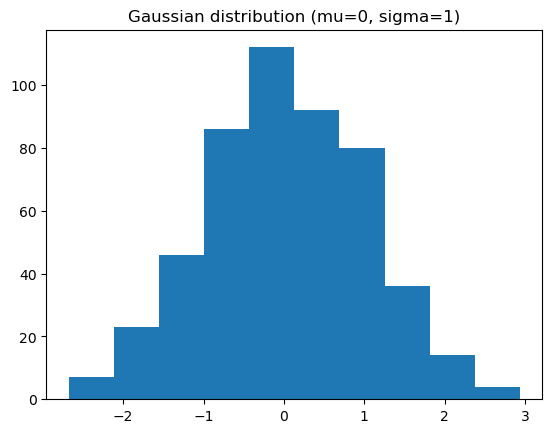

In [1]:
from random import gauss
import matplotlib.pyplot as plt
l = [gauss(0, 1) for _ in range(500)]
plt.hist(l)
plt.title('Gaussian distribution (mu=0, sigma=1)')
plt.show()

---
## 1. Global Land Temperature
This didactic version contains the formatted output files of the major cities of the globe with monthly granularity, between the years 1817 and 2012.

The dataset is composed of ∼200k rows corresponding to the measurements taken the first day of the month in a given city.
Each measurement is then described by 7 values:
- Date, when the measurement was taken
- AverageTemperature
- AverageTemperatureUncertainty
- City, from which the measurement was taken
- Country
- Latitude
- Longitude

In [2]:
#Import the csv
import csv

tempDs = [] #will be a list of lists

with open ("GLT_filtered.csv") as f:
    reader = csv.reader(f)
    tempDs=list(reader)

headers=tempDs[0]
tempDs=tempDs[1:]
for sample in tempDs:
    if sample[1]!= '':
        sample[1]=float(sample[1])
    else:
        sample[1]=None
    
    if sample[2]!= '':
        sample[2]=float(sample[2])
    else:
        sample[2]=None   
print(headers)
print(tempDs[0])


['Date', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude']
['1849-01-01', 26.704, 1.435, 'Abidjan', "CÃ´te D'Ivoire", '5.63N', '3.23W']


**1 - Which feature types are there?**
- Nominal: City, Country
- Continous: AvergaeTemperature, AvergaeTemperatureUncertainty, Latitude, Longitude
- Discrete: Date???

**2 - Fill missing values in the *AverageTemperature* attribute**

Analyze the attribute AverageTemperature, which contains missing values. Fill any gap with the arithmetic mean among the closest antecedent and the closest successive measurements in time, taken in the same city

In [3]:
# How many samples are missing the feature AvgTemp?
len(list(filter(lambda x: x[1]==None  ,tempDs)))

27581

I create two function that apply to a dataset (a list of lists) that contains only measurements of a single city ordered by city, country and data

In [4]:
#Given a cronological ordered list of lists that contains record
#about only one city, fills the avgTemp of first and last list if it is
#missing
def adjustTails(ds):
    k=0
    h=len(ds)-1

    while ds[0][1]==None:
        k+=1
        if ds[k][1]!= None:
            ds[0][1]=ds[k][1]/2
    
    while ds[len(ds)-1][1]==None:
        h-=1
        if ds[h][1]!=None:
            ds[len(ds)-1][1]=ds[h][1]/2

In [5]:
#Given a cronological ordered list of lists that contains record
#about only one city, fills the avgTemp of all the list (head and tail
#excluded) if it is missing
def fillAvgTemp(ds):
    adjustTails(ds)
    for i, sample in enumerate(ds):
        if sample[1]==None:
            prec=ds[i-1][1]
            succ=ds[i+1][1]
            j=0
            while succ == None:
                j+=1
                succ=ds[i+1+j][1]             
                
            sample[1]=(prec+succ)/2

This code below divdes the dataset by city: each element of the outer list is a list that contains only measurements related to a single city

In [6]:
#I assume that the tempDs is already ordered by city, country and data
#Create a list(whole ds) of lists(a single city) of lists(measures of that city)
#[ [ [], [], [] ], [ [], [],[]] ]
currentCity = tempDs[0][3]
currentCounty = tempDs[0][4]
listOfListsSingleCity=[]
listSingleCity=[]

for row in tempDs:
    if row[3]==currentCity and row[4]==currentCounty:
        listSingleCity.append(row)
    else:
        listOfListsSingleCity.append(listSingleCity)
        currentCity = row[3]
        currentCounty = row[4]
        listSingleCity=[]
        listSingleCity.append(row)
#I manage the last city since it does not go through the last else
listOfListsSingleCity.append(listSingleCity)

#print(listOfListsSingleCity[-1][:5])

In [7]:
for el in listOfListsSingleCity:# el is a list of lists
    fillAvgTemp(el)

In [8]:
# How many samples are missing the feature AvgTemp?
len(list(filter(lambda x: x[1]==None  ,tempDs)))

0

**3 - Hottest and Coldest**
Define a function that, given the name of a city and an integer N > 0, prints:
1. the top N hottest measurements;
2. the top N coldest measurements.

In [9]:
#return a list of ordered lists with the right city
def rightCityAndSorted(ds,cityName):
    rightCity=[l for l in ds if l[3]==cityName]#filter on the right city
    if len(rightCity)==0:
        print(f"{cityName} is not in the dataset")
        return None
    return sorted(rightCity, key=lambda x : x[1])#order by avg temperature

In [10]:
#given a ds (list of lists) return the top N and last N
def nHottestAndColdest(ds, cityName ,N):
    l = rightCityAndSorted(ds,cityName)
    if l == None:
        return
    if N <= 0:
        print("N cannot be <= 0")
        return
    coldest = l[:N]
    hottest = l[-N:][::-1]#takes last N and reverses it
    print(f'Top {N} hottest:')
    for el in hottest:
        print(f'{el[1]:.2f}')
    print(f'\nTop {N} coldest:')
    for el in coldest:
        print(f'{el[1]:.2f}')

In [11]:
nHottestAndColdest(tempDs, 'Rome',2)

Top 2 hottest:
25.95
25.00

Top 2 coldest:
-1.44
-1.30


_____
## 2. Textual data preparation on IMDB reviews
This exercise is meant to get you acquainted with the preprocessing of textual data.

Let’s imagine the IMDb platform wants an automatic procedure to assign a numerical value to a user review, based of the content of the text, to identify the rate he or she would have given to the movie. Simplifying the task, you might want to assign a label, Positive or Negative, to identify the overall sentiment, i.e. whether the user liked the movie or not. To do so, you will implement the TF-IDF weighting scheme on IMDb reviews. Then, you will compute the distance between a review whose sentiment is unknown and the two sets of positive and negative comments, assigning the sentiment of the closest one among the two.

**1 - Load the IMDb dataset as a list of lists**

In [12]:
import csv

IMDBbDs=[]

with open("aclimdb_reviews_train.txt", encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    IMDBbDs=list(reader) 
headers=IMDBbDs[0]
IMDBbDs=IMDBbDs[1:]
X=[x[0] for x in IMDBbDs]
y=[x[1] for x in IMDBbDs]

In [13]:
print(X[0])
print('\n', y[0])

For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.

 1


**2. Apply the tokenization function**

The tokenization procedure splits each comment in tokens (i.e.
separate words).

In [14]:
import string

def tokenize(docs):
    """Compute the tokens for each document.
    Input: a list of strings. Each item is a document to tokenize.
    Output: a list of lists. Each item is a list containing the tokens of the
    relative document.
    """
    tokens = []

    for doc in docs:
        for punct in string.punctuation:
            doc = doc.replace(punct, " ")
        split_doc = [ token.lower() for token in doc.split(" ") if token ]
        tokens.append(split_doc)
    
    return tokens

lTokens = tokenize(X)

#Tokens of the first document
print(lTokens[0])

['for', 'a', 'movie', 'that', 'gets', 'no', 'respect', 'there', 'sure', 'are', 'a', 'lot', 'of', 'memorable', 'quotes', 'listed', 'for', 'this', 'gem', 'imagine', 'a', 'movie', 'where', 'joe', 'piscopo', 'is', 'actually', 'funny', 'maureen', 'stapleton', 'is', 'a', 'scene', 'stealer', 'the', 'moroni', 'character', 'is', 'an', 'absolute', 'scream', 'watch', 'for', 'alan', 'the', 'skipper', 'hale', 'jr', 'as', 'a', 'police', 'sgt']


**3 - Computation of the term frequency (TF)**

Perform the computation of the term frequency (TF) of each token within its respective document. Although there exist different techniques to evaluate the frequency, we will now assume that the TF of a token t in a document d is equal to the number of occurrences of t in d.

Compute the TF for all your reviews.

Example of TF on a toy sentence:

tokens = ['with', 'great', 'power', 'comes', 'great', 'responsibility']

TF(tokens) = {'with': 1, 'great': 2, 'power': 1, 'comes': 1, 'responsibility': 1}

In [15]:
#This function is built to test the algorithm.

#tokens is a list of tokens of a single document (all the words of a single document)

def TF(tokens):
    tf = {}
    for token in tokens:
        if token in tf.keys():
            tf[token]+=1
        else:
            tf[token]=1
    print(tf)

# Test on a single document
TF(lTokens[0])

{'for': 3, 'a': 5, 'movie': 2, 'that': 1, 'gets': 1, 'no': 1, 'respect': 1, 'there': 1, 'sure': 1, 'are': 1, 'lot': 1, 'of': 1, 'memorable': 1, 'quotes': 1, 'listed': 1, 'this': 1, 'gem': 1, 'imagine': 1, 'where': 1, 'joe': 1, 'piscopo': 1, 'is': 3, 'actually': 1, 'funny': 1, 'maureen': 1, 'stapleton': 1, 'scene': 1, 'stealer': 1, 'the': 2, 'moroni': 1, 'character': 1, 'an': 1, 'absolute': 1, 'scream': 1, 'watch': 1, 'alan': 1, 'skipper': 1, 'hale': 1, 'jr': 1, 'as': 1, 'police': 1, 'sgt': 1}


In [16]:
#For each word in the document this function count the number of occurences
#inside that document.

#lTokens is a list of lists of tokens of a single document
#(all the words of a single document)
    
def lTF(lTokens):
    lTf=[] #is a list of dict that contains the TF
    for tokens in lTokens:
        tf = {}     
        for token in tokens:
            if token in tf.keys():
                tf[token]+=1
            else:
                tf[token]=1
        lTf.append(tf)
    return lTf

TFs = lTF(lTokens)
print(TFs[0])

{'for': 3, 'a': 5, 'movie': 2, 'that': 1, 'gets': 1, 'no': 1, 'respect': 1, 'there': 1, 'sure': 1, 'are': 1, 'lot': 1, 'of': 1, 'memorable': 1, 'quotes': 1, 'listed': 1, 'this': 1, 'gem': 1, 'imagine': 1, 'where': 1, 'joe': 1, 'piscopo': 1, 'is': 3, 'actually': 1, 'funny': 1, 'maureen': 1, 'stapleton': 1, 'scene': 1, 'stealer': 1, 'the': 2, 'moroni': 1, 'character': 1, 'an': 1, 'absolute': 1, 'scream': 1, 'watch': 1, 'alan': 1, 'skipper': 1, 'hale': 1, 'jr': 1, 'as': 1, 'police': 1, 'sgt': 1}


**4 - Compute the inverse document frequency (IDF).**




(a) Compute the DF for all of your tokens

In [17]:
#Calculate DF, takes as argument a list of lists of token
def DF(lTokens):
    
    #for each document turn a list of token in a set of (unique) tokens
    #so it removes duplicates document-wise
    lSetTokens = [set(l) for l in lTokens]
    
    #set of all token present in the collection (no duplicates)
    allTokens = set([el for s in lSetTokens for el in s])
    
    N = len(lTokens) #Count number of documents
    
    output = {} #dict {token, DFt}
    
    for token in allTokens:
        DFt = 0
        for tokens in lSetTokens:
            if token in tokens:
                DFt+=1
        output[token] = DFt
    return output
#return a dict {token, DF}

In [18]:
dfs = DF(lTokens)

In [19]:
dfs["for"]

17883

(b) Compute the IDF for all of your tokens

In [20]:
#Calculate IDF, takes as argument the output of the function DF and
#the argument of the function DF
import math
def IDF(dfs, lTokens): #dfs is a dict (token, DF)
    N = len(lTokens)
    return {k:math.log(N/v) for k,v in dfs.items()}
#return a dict {token, IDFt}

In [21]:
IDFs=IDF(dfs,lTokens)

(c) Try to sort the IDF values in ascending order. Which tokens (i.e. words) came to the top? Can you figure out why?

In [22]:
#ordering the dict
IDFs={k:v for k,v in sorted(IDFs.items(), key=lambda item: item[1])}
print(list(IDFs.keys())[0])
print(list(IDFs.values())[0])

the
0.008314469604085238


The word with the lowest IDF is the article "the" since it is very common.

____
Create a single function to compute IDF.


In [23]:
#Where lTokens is a list of lists of tokens of a single document 
#(all the words of a single document)
import numpy as np
def lIDF(lTokens):
    lSetTokens = [set(l) for l in lTokens] # is a list of sets. Each set is a document
    allTokens = set([el for s in lSetTokens for el in s]) #set containig all tokens across all documents
    N = len(lTokens) #number of documents
    
    output = {} #dict {token, IDFt}
    for token in allTokens:
        DFt = 0
        for tokens in lSetTokens:
            if token in tokens:
                DFt+=1
        IDFt = np.log(N/DFt)
        if IDFt >= 0: #change the parameter if you want to filter on the IDFt
            output[token] = IDFt
    return output

In [24]:
#Debugging purposes
lTokensProva = [ ['with', 'great', 'power', 'comes', 'great', 'responsibility'], ['white','shark','power']]
print("funzione doppia")
print(IDF(DF(lTokensProva),lTokensProva))
print()
print("funzione singola")
print(lIDF(lTokensProva))
diz = {'a':1,'b':2}
print('prova IDF')
#print(IDF(diz))

funzione doppia
{'shark': 0.6931471805599453, 'comes': 0.6931471805599453, 'great': 0.6931471805599453, 'with': 0.6931471805599453, 'responsibility': 0.6931471805599453, 'power': 0.0, 'white': 0.6931471805599453}

funzione singola
{'shark': 0.6931471805599453, 'comes': 0.6931471805599453, 'great': 0.6931471805599453, 'with': 0.6931471805599453, 'responsibility': 0.6931471805599453, 'power': 0.0, 'white': 0.6931471805599453}
prova IDF


___

**5 - Compute the TF-IDF**
Combine the definitions of term frequency (TF) and inverse document frequency (IDF), to produce a composite weight for each term in each document.The TF-IDF weighting scheme assigns to a term t a weight in the document d given by:
$$TF-IDF_{t,d} = TF_{t,d} × IDF_t$$

In other words, TF-IDFt;d assigns to term t a weight in document d that is
- high when t occurs many times within a small number of documents;
- low when the term occurs fewer times in a document, or occurs in many documents (thus offering a less pronounced relevance signal);
- lowest when the term occurs in virtually all documents.

*Crea una lista di dizionari (uno per ogni documento) che contengono solo le parole parole presenti in quel documento come chiave e come valore il parametro.*

In [25]:
#TFs is a list of dict (one for each document) that contains the TFs
#IDFs is a dict {token, IDFt}
def TFIDF(TFs, IDFs):
    output=[]
    for dTFs in TFs:
        dTFIDF = {k:v*IDFs[k] for k,v in dTFs.items()}
        output.append(dTFIDF)
    return output

In [26]:
TFIDFs = TFIDF(TFs, IDFs)

In [27]:
#Test
print(TFIDFs[0])
a={k:v for k,v in sorted(TFIDFs[0].items(), key=lambda item: item[1],reverse = True)}
print()
print("Token with highest TFIDF:")
print(list(a.keys())[0],":", list(a.values())[0])


{'for': 1.005075851886905, 'a': 0.16757709668908488, 'movie': 0.9813925049416498, 'that': 0.20722099077039452, 'gets': 2.257229391273248, 'no': 1.1141321003261466, 'respect': 3.9845936982629815, 'there': 0.837387134278689, 'sure': 2.3530366364901436, 'are': 0.5868431101899066, 'lot': 2.0319474551515233, 'of': 0.05226218466281087, 'memorable': 3.6936910111111585, 'quotes': 5.5940316106970815, 'listed': 5.339139361068292, 'this': 0.09924591465797242, 'gem': 4.291820366787733, 'imagine': 3.587045148232668, 'where': 1.655900786844441, 'joe': 4.137669686960474, 'piscopo': 7.418580902748128, 'is': 0.3258307041721464, 'actually': 1.982532640511814, 'funny': 2.0743346043116913, 'maureen': 6.437751649736401, 'stapleton': 7.561681746388801, 'scene': 1.8767946184246356, 'stealer': 7.487573774235079, 'the': 0.016628939208170476, 'moroni': 8.740336742730447, 'character': 1.641547966352334, 'an': 0.7166205367455873, 'absolute': 4.315490110873637, 'scream': 4.706096104578052, 'watch': 1.5199629060064